In [1]:
import sys
sys.path.append('..')

In [2]:
import os
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import lightning.pytorch as pl
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from peft import get_peft_config, PeftModel, PeftConfig, inject_adapter_in_model, LoraConfig, get_peft_model

2024-12-31 14:04:51.648499: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-31 14:04:51.651092: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-31 14:04:51.656832: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-31 14:04:51.667816: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-31 14:04:51.667837: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting t

In [4]:
import esm

In [5]:
from Bio import SeqIO

In [6]:
df = pd.read_csv('/nethome/kgeorge/workspace/DomainPrediction/Data/al_test_experiments/Envision/TEM1.csv')
df = df[df['mut_type'] == 'missense']

In [7]:
wt_path = os.path.join('/nethome/kgeorge/workspace/DomainPrediction/Data/al_test_experiments/Envision/TEM1.fasta')
for seq_record in SeqIO.parse(wt_path, "fasta"):
    wt = str(seq_record.seq)

In [8]:
new_df = {'seq': [],
          'log_fitness': [],
          'mutated_position': [],
          'PID': []
          }
for _i, row in df.iterrows():
    pos = row['position']-1
    assert wt[pos] == row['aa1']
    seq = wt[:pos] + row['aa2'] + wt[pos+1:]
    assert len(seq) == len(wt)
    assert seq[pos] == row['aa2']
    for _j, (aa1, aa2) in enumerate(zip(wt, seq)):
        if _j != pos:
            assert aa1 == aa2
    
    new_df['seq'].append(seq)
    new_df['log_fitness'].append(row['scaled_effect1'])
    new_df['mutated_position'].append(pos)
    new_df['PID'].append(_i)

new_df = pd.DataFrame(new_df)

In [9]:
test_data = new_df.sample(frac=0.2, random_state=0)
train_data = new_df.drop(test_data.index)

In [10]:
train_data.shape, test_data.shape

((4158, 4), (1040, 4))

In [11]:
train_data.head()

,seq,log_fitness,mutated_position,PID
0,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,1.142208,57,71
1,MSIQHFRVALIPFFAAFCWPVFAHPETLVKVKDAEDQLGARVGYIE...,1.094952,18,101
2,MSIQHFRVALIPFFYAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,1.072459,14,116
3,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,1.067029,181,123
5,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,1.067029,156,125


In [12]:
# model_path='/data/users/kgeorge/workspace/esm1v/esm1v_t33_650M_UR90S_1.pt'
# # model_path='/data/users/kgeorge/workspace/esm2/checkpoints/esm2_t33_650M_UR50D.pt'
# # model_path='/data/users/kgeorge/workspace/esm2/checkpoints/esm2_t6_8M_UR50D.pt'
# model, alphabet = esm.pretrained.load_model_and_alphabet(model_path)
# batch_converter = alphabet.get_batch_converter()
# # model_reg, _ = esm.pretrained.load_model_and_alphabet(os.path.join(model_loc, model_name))
# # for pm in model_reg.parameters():
# #     pm.requires_grad = False
# # model_reg.eval()
# peft_config = LoraConfig(
#     r=8,
#     lora_alpha=8,
#     lora_dropout=0.1,
#     target_modules=["q_proj", "v_proj"],
#     # bias='all'
# )
# model = get_peft_model(model, peft_config)

In [13]:
# model.model_version

In [14]:
# model

In [15]:
# model.print_trainable_parameters()

In [16]:
# for name, param in model.named_parameters():
#     # if param.requires_grad:
#     print(name, param.requires_grad)

In [17]:
# pos

In [18]:
# model = model.cuda()
# # model = basemodel.cuda()

In [19]:
# data = [
#     ('Pwt', wt)
#     ]
# _, _, batch_tokens_wt = batch_converter(data)

In [20]:
# batch_tokens_wt

In [21]:
# x, y, pos = train_data['seq'][:4].to_numpy(), train_data['log_fitness'][:4].to_numpy(), train_data['mutated_position'][:4].to_numpy()
# data = [
#     (fun, seq) for (seq, fun) in zip(x, y)
#     ]
# batch_labels, batch_strs, batch_tokens = batch_converter(data)
# batch_lens = (batch_tokens != alphabet.padding_idx).sum(1)

# print(batch_tokens.shape)
# batch_tokens_masked = batch_tokens.clone()
# for i in range(batch_tokens.shape[0]):
#     batch_tokens_masked[i, pos[i]+1] = alphabet.mask_idx

# logits = model(batch_tokens_masked.cuda())['logits']
# log_probs = torch.log_softmax(logits, dim=-1)

In [22]:
# logits

In [23]:
# batch_tokens[0][pos[0]+1], batch_tokens_wt[0][pos[0]+1]

In [24]:
# scores = []
# for i in range(log_probs.shape[0]):
#     scores.append(log_probs[i, pos[i]+1, batch_tokens[i][pos[i]+1]] - log_probs[i, pos[i]+1, batch_tokens_wt[0][pos[i]+1]])
# scores = torch.stack(scores, dim=0)
# print(scores.shape)

In [25]:
# scores

In [26]:
# golden_score = torch.tensor(y)

In [27]:
# golden_score

In [28]:
# c_pos_loss = []
# c_neg_loss = []
# for i in range(len(scores)):
#     for j in range(i, len(scores)):
#         if golden_score[i] > golden_score[j]:
#             # loss += torch.log(1+torch.exp(scores[j]-scores[i]))
#             if scores[j] > scores[i]:
#                 c_pos_loss.append(torch.log(1+torch.exp(scores[j]-scores[i])).cpu().item())
#             else:
#                 c_neg_loss.append(torch.log(1+torch.exp(scores[j]-scores[i])).cpu().item())
#         else:
#             # loss += torch.log(1+torch.exp(scores[i]-scores[j]))
#             if scores[i] > scores[j]:
#                 c_pos_loss.append(torch.log(1+torch.exp(scores[i]-scores[j])).cpu().item())
#             else:
#                 c_neg_loss.append(torch.log(1+torch.exp(scores[i]-scores[j])).cpu().item())

In [29]:
# plt.hist(c_pos_loss, label='pos loss')
# plt.hist(c_neg_loss, label='neg loss')
# plt.legend()
# plt.show()

In [30]:
# def BT_loss(scores, golden_score):
#     loss = torch.tensor(0.)
#     loss = loss.cuda()
#     for i in range(len(scores)):
#         for j in range(i, len(scores)):
#             if golden_score[i] > golden_score[j]:
#                 loss += torch.log(1+torch.exp(scores[j]-scores[i]))
#             else:
#                 loss += torch.log(1+torch.exp(scores[i]-scores[j]))
#     return loss


In [31]:
# l_BT = BT_loss(scores, golden_score)

In [32]:
# l_BT

In [33]:
# logits_reg = model_reg(batch_tokens_wt)['logits']
# logits_reg = logits_reg.repeat(16, 1, 1)

In [34]:
# logits_reg.shape, logits.shape

In [35]:
# creterion_reg = torch.nn.KLDivLoss(reduction='batchmean')
# probs = torch.softmax(logits, dim=-1)
# probs_reg = torch.softmax(logits_reg, dim=-1)
# l_reg = creterion_reg(probs_reg.log().cuda(), probs)

In [36]:
# l_reg

In [37]:
train_data.head()

,seq,log_fitness,mutated_position,PID
0,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,1.142208,57,71
1,MSIQHFRVALIPFFAAFCWPVFAHPETLVKVKDAEDQLGARVGYIE...,1.094952,18,101
2,MSIQHFRVALIPFFYAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,1.072459,14,116
3,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,1.067029,181,123
5,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,1.067029,156,125


In [38]:
class ProteinFunDatasetContrast(Dataset):
    def __init__(self, df, wt):
        self.seq, self.y = df['seq'].to_numpy(), df['log_fitness'].to_numpy()
        self.pos = df['mutated_position'].to_numpy()
        self.wt = np.array([wt]*self.seq.shape[0])
    
    def __len__(self):
        return self.seq.shape[0]
    
    def __getitem__(self, idx):
        return self.seq[idx], self.y[idx], self.pos[idx], self.wt[idx]

In [39]:
dataset = ProteinFunDatasetContrast(train_data, wt)

In [40]:
dataset[0]

('MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIELDLNSGKILESNRPEERFPMMSTFKVLLCGAVLSRVDAGQEQLGRRIHYSQNDLVEYSPVTEKHLTDGMTVRELCSAAITMSDNTAANLLLTTIGGPKELTAFLHNMGDHVTRLDRWEPELNEAIPNDERDTTMPAAMATTLRKLLTGELLTLASRQQLIDWMEADKVAGPLLRSALPAGWFIADKSGAGERGSRGIIAALGPDGKPSRIVVIYTTGSQATMDERNRQIAEIGASLIKHW',
 1.142207789,
 57,
 'MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIELDLNSGKILESFRPEERFPMMSTFKVLLCGAVLSRVDAGQEQLGRRIHYSQNDLVEYSPVTEKHLTDGMTVRELCSAAITMSDNTAANLLLTTIGGPKELTAFLHNMGDHVTRLDRWEPELNEAIPNDERDTTMPAAMATTLRKLLTGELLTLASRQQLIDWMEADKVAGPLLRSALPAGWFIADKSGAGERGSRGIIAALGPDGKPSRIVVIYTTGSQATMDERNRQIAEIGASLIKHW')

In [41]:
class ESM2ConFit(pl.LightningModule):
    def __init__(self, config) -> None:
        super().__init__()
        self.config = config

        self.basemodel, self.alphabet = esm.pretrained.load_model_and_alphabet(config['model_path'])
        self.model_reg, _ = esm.pretrained.load_model_and_alphabet(config['model_path'])
        self.batch_converter = self.alphabet.get_batch_converter()
        
        for pm in self.model_reg.parameters():
            pm.requires_grad = False
        self.model_reg.eval()
        
        peft_config = LoraConfig(
            r=8,
            lora_alpha=8,
            lora_dropout=0.1,
            target_modules=["q_proj", "v_proj"],
            bias='all'
        )
        
        self.model = get_peft_model(self.basemodel, peft_config)
        
        if config['device'] == 'gpu':
            self.model.cuda()
            self.model_reg.cuda()

        self.lambda_reg = config['lambda']

        self.accumulate_batch_loss_train = []
        self.accumulate_batch_loss_val = []
        self.debug=True

    def forward(self, batch_tokens_masked, batch_tokens, batch_tokens_wt, pos):
        
        logits = self.model(batch_tokens_masked)['logits']
        log_probs = torch.log_softmax(logits, dim=-1)

        scores = torch.zeros(log_probs.shape[0])
        if self.config['device'] == 'gpu':
            scores = scores.cuda()

        # print(log_probs)
        for i in range(log_probs.shape[0]):
            # print(pos[i]+1)
            # print(batch_tokens[i][pos[i]+1], batch_tokens_wt[i][pos[i]+1])
            # print(log_probs[i, pos[i]+1, batch_tokens[i][pos[i]+1]] - log_probs[i, pos[i]+1, batch_tokens_wt[i][pos[i]+1]])
            scores[i] = log_probs[i, pos[i]+1, batch_tokens[i][pos[i]+1]] - log_probs[i, pos[i]+1, batch_tokens_wt[i][pos[i]+1]]
        
        # print(scores)
        return scores, logits
    
    def BT_loss(self, scores, golden_score):
        loss = torch.tensor(0.)
        if self.config['device'] == 'gpu':
            loss = loss.cuda()

        for i in range(len(scores)):
            for j in range(i, len(scores)):
                if golden_score[i] > golden_score[j]:
                    loss += torch.log(1 + torch.exp(scores[j]-scores[i]))
                else:
                    loss += torch.log(1 + torch.exp(scores[i]-scores[j]))
        return loss

    
    def training_step(self, batch, batch_idx):
        seq, y, pos, wt = batch
        data = [
            (f'P{i}', wt_i) for i, wt_i in enumerate(wt)
            ]
        _, _, batch_tokens_wt = self.batch_converter(data)

        data = [
            (fun, s) for (s, fun) in zip(seq, y)
            ]
        batch_labels, batch_strs, batch_tokens = self.batch_converter(data)
        batch_lens = (batch_tokens != self.alphabet.padding_idx).sum(1)

        batch_tokens_masked = batch_tokens.clone()
        for i in range(batch_tokens.shape[0]):
            batch_tokens_masked[i, pos[i]+1] = self.alphabet.mask_idx

        if self.config['device'] == 'gpu':
            batch_tokens_masked = batch_tokens_masked.cuda()

        y_hat, logits = self(batch_tokens_masked, batch_tokens, batch_tokens_wt, pos)

        bt_loss = self.BT_loss(y_hat, y)

        if self.config['device'] == 'gpu':
            batch_tokens_wt = batch_tokens_wt.cuda()

        logits_reg = self.model_reg(batch_tokens_wt)['logits']

        creterion_reg = torch.nn.KLDivLoss(reduction='batchmean')
        probs = torch.softmax(logits, dim=-1)
        probs_reg = torch.softmax(logits_reg, dim=-1)
        l_reg = creterion_reg(probs_reg.log().cuda(), probs)

        loss = bt_loss + self.lambda_reg*l_reg

        # print(bt_loss)
        # print(l_reg)
        # print(logits)

        self.log("train/loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        self.accumulate_batch_loss_train.append(loss.item())
        
        return loss
    
    def validation_step(self, batch, batch_idx):
        seq, y, pos, wt = batch
        data = [
            (f'P{i}', wt_i) for i, wt_i in enumerate(wt)
            ]
        _, _, batch_tokens_wt = self.batch_converter(data)

        data = [
            (fun, s) for (s, fun) in zip(seq, y)
            ]
        batch_labels, batch_strs, batch_tokens = self.batch_converter(data)
        batch_lens = (batch_tokens != self.alphabet.padding_idx).sum(1)

        batch_tokens_masked = batch_tokens.clone()
        for i in range(batch_tokens.shape[0]):
            batch_tokens_masked[i, pos[i]+1] = self.alphabet.mask_idx

        if self.config['device'] == 'gpu':
            batch_tokens_masked = batch_tokens_masked.cuda()

        y_hat, logits = self(batch_tokens_masked, batch_tokens, batch_tokens_wt, pos)

        bt_loss = self.BT_loss(y_hat, y)

        if self.config['device'] == 'gpu':
            batch_tokens_wt = batch_tokens_wt.cuda()

        logits_reg = self.model_reg(batch_tokens_wt)['logits']

        creterion_reg = torch.nn.KLDivLoss(reduction='batchmean')
        probs = torch.softmax(logits, dim=-1)
        probs_reg = torch.softmax(logits_reg, dim=-1)
        l_reg = creterion_reg(probs_reg.log().cuda(), probs)

        loss = bt_loss + self.lambda_reg*l_reg

        self.log("val/loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        self.accumulate_batch_loss_val.append(loss.item())
    
    def trainmodel(self, df, wt, val=None, debug=True):
        self.train()
        
        self.debug = debug

        train_dataset = ProteinFunDatasetContrast(df, wt)

        val_loader = None
        if val is not None:
            val_dataset = ProteinFunDatasetContrast(val, wt)
            val_loader = DataLoader(val_dataset, batch_size=self.config['batch_size'], shuffle=False)
        
        train_loader = DataLoader(train_dataset, batch_size=self.config['batch_size'], shuffle=True)
        # train_loader = DataLoader(train_dataset, batch_size=self.config['batch_size'], shuffle=False)

        callbacks = None
        if self.config['early_stopping']:
            callbacks = []
            earlystopping_callback = EarlyStopping(monitor="val/loss", patience=self.config['patience'], verbose=False, mode="min")
            callbacks.append(earlystopping_callback)


        trainer = pl.Trainer(max_epochs=self.config['epoch'], callbacks=callbacks,
                                accelerator="auto",
                                enable_progress_bar=True,
                                enable_model_summary=True,
                                precision="16-mixed",
                                # accumulate_grad_batches=self.config['accumulate_batch_size']
                                )
        
        trainer.fit(model=self, train_dataloaders=train_loader, val_dataloaders=val_loader)

    def on_train_epoch_start(self):
        self.accumulate_batch_loss_train.clear()
        self.accumulate_batch_loss_val.clear()
    
    def on_train_epoch_end(self):
        if self.current_epoch % self.config['print_every_n_epoch'] == 0 and self.debug:
            print(f'Epoch: {self.current_epoch}: train mse: {np.mean(self.accumulate_batch_loss_train)} val mse: {np.mean(self.accumulate_batch_loss_val)}')

    def on_train_end(self):
        print(f'Epoch: {self.current_epoch}: train mse: {np.mean(self.accumulate_batch_loss_train)} val mse: {np.mean(self.accumulate_batch_loss_val)}')

    def predict(self, X, setting='cpu', batch_size=16):
        seq, pos, wt = X

        # print(pos)

        print(f'predict len : {seq.shape[0]}')
        if setting=='cpu':
            self.cpu()
            assert next(self.parameters()).is_cuda == False
            pred = []
            for i in tqdm(range(0, len(seq), batch_size)):
                with torch.no_grad():
                    pos_batch = pos[i:i+batch_size]
                    data = [
                        (f'W{_i}', wt_i) for _i, wt_i in enumerate(wt[i:i+batch_size])
                        ]
                    _, _, batch_tokens_wt = self.batch_converter(data)

                    print(wt[i:i+batch_size])

                    data = [
                        (f'P{_i}', s) for _i, s in enumerate(seq[i:i+batch_size])
                        ]
                    batch_labels, batch_strs, batch_tokens = self.batch_converter(data)
                    batch_lens = (batch_tokens != self.alphabet.padding_idx).sum(1)

                    batch_tokens_masked = batch_tokens.clone()
                    for _i in range(batch_tokens.shape[0]):
                        batch_tokens_masked[_i, pos_batch[_i]+1] = self.alphabet.mask_idx

                    y_pred, _ = self(batch_tokens_masked, batch_tokens, batch_tokens_wt, pos_batch)
                    
                    pred.append(y_pred.cpu().numpy().flatten())

            pred = np.concatenate(pred)
        else:
            self.cuda()
            assert next(self.parameters()).is_cuda == True
            pred = []
            for i in tqdm(range(0, len(seq), batch_size)):
                with torch.no_grad():
                    pos_batch = pos[i:i+batch_size]
                    data = [
                        (f'W{_i}', wt_i) for _i, wt_i in enumerate(wt[i:i+batch_size])
                        ]
                    _, _, batch_tokens_wt = self.batch_converter(data)

                    # print(wt[i:i+batch_size])

                    data = [
                        (f'P{_i}', s) for _i, s in enumerate(seq[i:i+batch_size])
                        ]
                    batch_labels, batch_strs, batch_tokens = self.batch_converter(data)
                    batch_lens = (batch_tokens != self.alphabet.padding_idx).sum(1)

                    batch_tokens_masked = batch_tokens.clone()
                    for _i in range(batch_tokens.shape[0]):
                        batch_tokens_masked[_i, pos_batch[_i]+1] = self.alphabet.mask_idx

                    batch_tokens_masked = batch_tokens_masked.cuda()

                    # print(batch_tokens_masked.shape, batch_tokens.shape, batch_tokens_wt.shape)
                    # print(wt[i:i+batch_size].shape, pos[i:i+batch_size].shape)
                    # print(i, i+batch_size, pos[i:i+batch_size])

                    y_pred, _ = self(batch_tokens_masked, batch_tokens, batch_tokens_wt, pos_batch)

                    # print(y_pred)

                    pred.append(y_pred.cpu().numpy().flatten())

            pred = np.concatenate(pred)

        return pred

    def configure_optimizers(self):
        return torch.optim.AdamW(self.model.parameters(), lr=0.0001)

In [42]:
config={'model_path': '/data/users/kgeorge/workspace/esm1v/esm1v_t33_650M_UR90S_1.pt',
        'epoch': 3, 
        'batch_size': 4,
        'lambda': 0.1,
        'accumulate_batch_size': 32,
        'patience': 10,
        'early_stopping': False,
        'lr': 5e-4,
        'print_every_n_epoch': 1,
        'device': 'gpu'}
surrogate = ESM2ConFit(config=config)
surrogate.model.print_trainable_parameters()

/nethome/kgeorge/miniconda3/envs/workspace-esm/lib/python3.10/site-packages/esm/pretrained.py:215: UserWarning: Regression weights not found, predicting contacts will not produce correct results.
  warnings.warn(


trainable params: 1,820,194 || all params: 653,708,214 || trainable%: 0.2784


In [ ]:
# can remove model_reg out

In [49]:
surrogate.trainmodel(df=train_data, wt=wt, val=test_data)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX A2000 12GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | basemodel | ProteinBertModel | 653 M  | train
1 | model_reg | ProteinBertModel | 652 M  | train
2 | model     | PeftModel        | 653 M  | train
-------------------------------------------------------
1.8 M     Trainable params
1.3 B     Non-trainable params
1.3 B     Total params
5,224.259 Total estimated model params siz

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/nethome/kgeorge/miniconda3/envs/workspace-esm/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.
/nethome/kgeorge/miniconda3/envs/workspace-esm/lib/python3.10/site-packages/lightning/pytorch/utilities/data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 4. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
/nethome/kgeorge/miniconda3/envs/workspace-esm/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

/nethome/kgeorge/miniconda3/envs/workspace-esm/lib/python3.10/site-packages/lightning/pytorch/utilities/data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 2. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch: 0: train mse: 6.518667620076583 val mse: 6.13902904345439


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch: 1: train mse: 5.851104224415926 val mse: 5.880066090363723


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch: 2: train mse: 5.624945022968146 val mse: 5.7585572600364685


`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch: 3: train mse: 5.624945022968146 val mse: 5.7585572600364685


In [ ]:
# for name, param in surrogate.named_parameters():
#     if param.requires_grad:
#         print(name)

In [43]:
_wt = wt

In [44]:
from scipy import stats

In [45]:
ypred = surrogate.predict((train_data['seq'].to_numpy(), train_data['mutated_position'].to_numpy(), np.array([wt]*train_data.shape[0])), 
                  setting='gpu', batch_size=4)
y = train_data['log_fitness'].to_numpy()

predict len : 4158


100%|██████████| 1040/1040 [08:47<00:00,  1.97it/s]


0.67


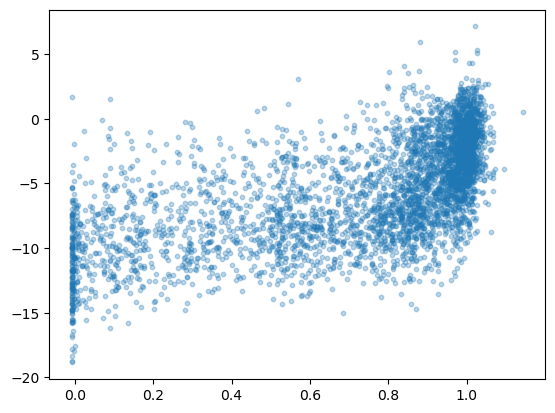

In [46]:
corr = stats.spearmanr(y, ypred)
s_corr = round(corr.statistic, 2)
print(s_corr)
plt.scatter(y, ypred, s=10, alpha=0.3)

In [47]:
ypred = surrogate.predict((test_data['seq'].to_numpy(), test_data['mutated_position'].to_numpy(), np.array([wt]*test_data.shape[0])), 
                  setting='gpu', batch_size=4)
y = test_data['log_fitness'].to_numpy()

predict len : 1040


100%|██████████| 260/260 [02:07<00:00,  2.04it/s]


0.68


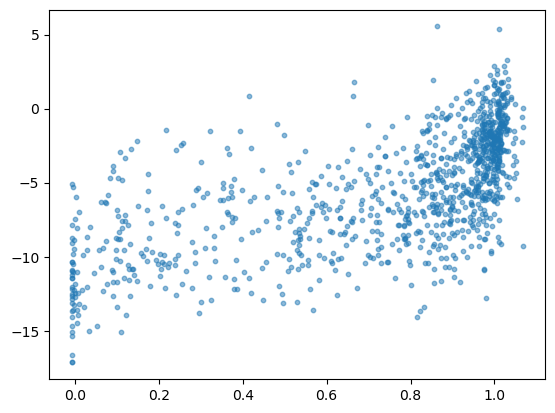

In [48]:
corr = stats.spearmanr(y, ypred)
s_corr = round(corr.statistic, 2)
print(s_corr)
plt.scatter(y, ypred, s=10, alpha=0.5)

In [50]:
wt

'MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIELDLNSGKILESFRPEERFPMMSTFKVLLCGAVLSRVDAGQEQLGRRIHYSQNDLVEYSPVTEKHLTDGMTVRELCSAAITMSDNTAANLLLTTIGGPKELTAFLHNMGDHVTRLDRWEPELNEAIPNDERDTTMPAAMATTLRKLLTGELLTLASRQQLIDWMEADKVAGPLLRSALPAGWFIADKSGAGERGSRGIIAALGPDGKPSRIVVIYTTGSQATMDERNRQIAEIGASLIKHW'

In [53]:
ypred = surrogate.predict((train_data['seq'].to_numpy(), train_data['mutated_position'].to_numpy(), np.array([wt]*train_data.shape[0])), 
                  setting='gpu', batch_size=4)
y = train_data['log_fitness'].to_numpy()

predict len : 4158


100%|██████████| 1040/1040 [08:55<00:00,  1.94it/s]


0.87


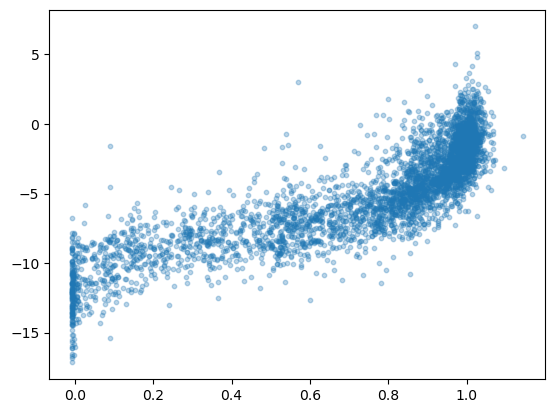

In [54]:
corr = stats.spearmanr(y, ypred)
s_corr = round(corr.statistic, 2)
print(s_corr)
plt.scatter(y, ypred, s=10, alpha=0.3)

In [51]:
ypred = surrogate.predict((test_data['seq'].to_numpy(), test_data['mutated_position'].to_numpy(), np.array([wt]*test_data.shape[0])), 
                  setting='gpu', batch_size=4)
y = test_data['log_fitness'].to_numpy()

predict len : 1040


100%|██████████| 260/260 [02:07<00:00,  2.04it/s]


0.86


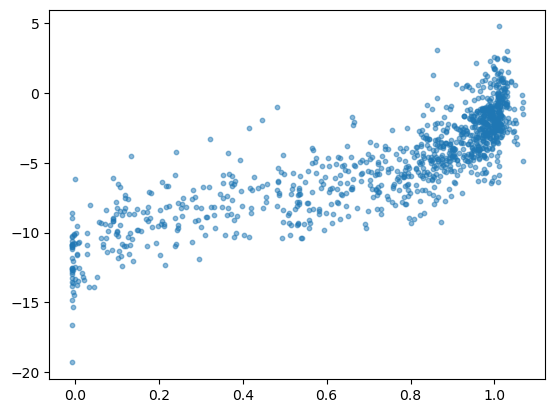

In [52]:
corr = stats.spearmanr(y, ypred)
s_corr = round(corr.statistic, 2)
print(s_corr)
plt.scatter(y, ypred, s=10, alpha=0.5)